In [ ]:
"""
Cording Plan

Things need tobe Prepared
・cifar10のスコア推定能力のあるmodel
・cifar10で生成された種類が特定できる画像データx0

Step1
def
・x0をΔtだけ拡散させたデータを100枚作成する。(x1_0, x1_99)
def
Step2
・x0とx1の対(100個)でBFGSを行い、条件を満たしたものをカウントする。
def
Step3
・複数の箇所で行って正確性を上げたBを出す。固有ベクトル参照。

"""

In [ ]:
"""Driveのマウント"""

In [1]:
%cd /content/drive/MyDrive/local_repo_all/Research_repo

/content/drive/MyDrive/local_repo_all/Research_repo


In [6]:
#@title sys.path
"""
import sys
sys.path
"""

'\nimport sys\nsys.path\n'

In [5]:
#@title moduleのパス追加 カレントディレクトリ以外も
import os
import sys

submodule_path = os.path.join(os.getcwd(), 'my-submodule')
mymodules_path = os.path.join(os.getcwd(), 'my_modules')

sys.path.append(submodule_path)
sys.path.append(mymodules_path)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch

#!pip install GPUtil
#import GPUtil

from configs.main_config import load_config
from sde import VPSDE
from run import score_fn

"""今後import"""
def bfgs_step(B, x, x_old, gradf, gradf_old):
  s = x - x_old
  y = gradf - gradf_old
  Bs = np.dot(B, s)
  B_next = B + np.dot(y,y.T)/np.dot(s.T, y) - np.dot(Bs, Bs.T)/np.dot(s.T, Bs)
  return B_next


if __name__ == '__main__':

  """機器の設定"""
  config = load_config()
  #torch.manual_seed(3407)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print(f'what is device: {device}')
  config['device'] = device   # 取得したデバイスをconfig に追加。ファイルの書き換えはない。

  torch.backends.cudnn.bechmark = True    # ベンチマークモードオン 最適化してくれて高速化するらしい。

  #GPUtil.showUtilization()

  data_path = os.path.join(os.getcwd(),"Data_tobe_loaded", "x0_sample.pt")
  model_path = os.path.join(os.getcwd(),"Data_tobe_loaded", "trained_model.pt")


  sde = VPSDE(config)

  """Model_Load"""
  model = torch.load(model_path)

  """Data_Load"""
  x0 = (torch.load(data_path)).to(config['device'])






what is device: cuda


In [33]:
#@title Class

class Observe_HessianMatrix():

  def __init__(self, sde, model, device):

    self.sde = sde
    self.model = model
    self.device = device

    """使用するpath設定"""
    self.observe_hessianmatrix_parent_path = os.path.join(os.getcwd(), "obs_he")
    self.perx_parent_path = os.path.join(self.observe_hessianmatrix_parent_path, "perx")
    self.perscore_parent_path = os.path.join(self.observe_hessianmatrix_parent_path, "perscore")
    self.Bnew_parent_path = os.path.join(self.observe_hessianmatrix_parent_path, "Bnew_all")

    self.B0 = np.identity(3*32*32)


  """使用する親ディレクトリ作成"""
  def dir_make(self):
    if os.path.exists(self.observe_hessianmatrix_parent_path)==False:
      os.mkdir(self.observe_hessianmatrix_parent_path)
    if os.path.exists(self.perx_parent_path)==False:
      os.mkdir(self.perx_parent_path)
    if os.path.exists(self.perscore_parent_path)==False:
      os.mkdir(self.perscore_parent_path)
    if os.path.exists(self.Bnew_parent_path)==False:
      os.mkdir(self.Bnew_parent_path)




  """x_startを1step拡散させた num枚のデータを返す"""
  def plural_forsde_step(self, x_start, num):
    """x_start: tensor, cuda, [1, 3, 32, 32]"""

    x = x_start
    #print(f'x.size(): {x.size()}')
    x = x.repeat(num, 1, 1, 1)
    #print(f'x.size(): {x.size()}')
    t = (torch.ones(num, device=self.device) / 1000) # all 1/1000
    mean, std = self.sde.marginal_prob(x, t)
    z = torch.randn_like(x)
    #print(f'x.size(): {x.size()}, mean.size(): {mean.size()}')
    perturbed_x = mean + std[:, None, None, None] * z
    score = score_fn(perturbed_x, t, self.model, self.sde)

    return perturbed_x, score


  """(plural_forsde_step用) per_x, score を num, timesを記載して保存"""
  def plural_forsde_save(self, per_x, score, num, times):
    perx_path = os.path.join(self.perx_parent_path, f'plural_per{num}_{times}.pth')
    perscore_path = os.path.join(self.perscore_parent_path, f'plural_per{num}_{times}.pth')

    torch.save(per_x, perx_path)
    torch.save(score, perscore_path)


  """(plural_forsde_save用)保存したデータのロード"""
  def plural_forsde_load(self, num, times):

    perx_path = os.path.join(self.perx_parent_path, f'plural_per{num}_{times}.pth')
    perscore_path = os.path.join(self.perscore_parent_path, f'plural_per{num}_{times}.pth')

    per_x = torch.load(perx_path)
    per_score = torch.load(perscore_path)

    return per_x, per_score







  """ndarray の B と tensorである２つのx, scoreからbfgsを行う式"""
  def bfgs_xandx_tensor(self, B, x1, x2, score1, score2):
    """x, score 次元は [1, 3, 32, 32]"""
    """2つのx, scoreを用意 対応次元の行き来に注意"""

    """numpy形式で、各データ用意"""
    x = torch.reshape(torch.flatten(x2), (-1, 1)).to('cpu').detach().numpy().copy()
    x_old = torch.reshape(torch.flatten(x1), (-1, 1)).to('cpu').detach().numpy().copy()
    gradf = torch.reshape(torch.flatten(score2), (-1, 1)).to('cpu').detach().numpy().copy()
    gradf_old = torch.reshape(torch.flatten(score1), (-1, 1)).to('cpu').detach().numpy().copy()

    Bnew = bfgs_step(B, x, x_old, gradf, gradf_old)

    return Bnew




  """
  B: ndarray, [n, n], x, score: tensor, [num, 3, 32, 32] を受け取り、
  num-1 回 BFGS公式で計算し、B_new: ndarray, [n, n] を返すモジュール
  x, scoreのセット跨る場合、num回。last_x, last_score を参照
  """
  def bfgs_repeat(self, B1, x, score, num, last_x=None, last_score=None):

    """セットを跨る場合の処理"""
    if (torch.is_tensor(last_x)) and (torch.is_tensor(last_score)) == True:
      x1 = last_x
      x2 = torch.unsqueeze(x[0], 0)
      score1 = last_score
      score2 = torch.unsqueeze(score[0], 0)
      B2 = self.bfgs_xandx_tensor(B1, x1, x2, score1, score2)
      B1 = B2


    """B, x1and2, socre1and2 の用意"""
    for i in range(num-1):
      x1 = torch.unsqueeze(x[i], 0) # tensor: [1, 3, 32, 32]
      x2 = torch.unsqueeze(x[i+1], 0)
      score1 = torch.unsqueeze(score[i], 0)
      score2 = torch.unsqueeze(score[i+1], 0)
      B2 = self.bfgs_xandx_tensor(B1, x1, x2, score1, score2)
      B1 = B2
      if (i==0) or (i%10 == 9) or (i==num-2):
        print(f'{i}times')

    B_new = B2
    last_x = x2
    last_score = score2

    return B_new, last_x, last_score


  """(bfgs_repeat用) B を num, times をつけて保存"""
  def save_B(self, B, num, times):
    B_path = os.path.join(self.Bnew_parent_path, f"B_{num}_{times}.npy")
    np.save(B_path, B)


  """(bfgs_repeat用) """
  def load_B(self, num, times):
    B_path = os.path.join(self.Bnew_parent_path, f"B_{num}_{times}.npy")
    B = np.load(B_path)

    return B




  """dataをhistogramとline_graphで可視化"""
  def hist_with_line(self, data):

    bins = 50
    # ヒストグラムのデータを計算（ビンの数とエッジ）
    counts, bin_edges = np.histogram(data, bins=bins)
    # ヒストグラムのビンの中心値を計算
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # ヒストグラムと折れ線グラフの描画
    fig, ax = plt.subplots(figsize=(10, 6))
    #ax.set_xlim(, under)
    # ヒストグラムの描画
    ax.hist(data, bins=bins, edgecolor='black', alpha=0.7)
    # 折れ線グラフの描画
    ax.plot(bin_centers, counts, marker='o', linestyle='-', color='red')

    ax.set_title('Histogram with Line Graph')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

    plt.show()


  """np.linalg.eig は多少時間がかかるのでon, offのため、関数には組み込まない"""
  # valuse, vectors = np.linalg.eig(B)
  def eigenvalue_distribution(self, values, over=0.99, under=1.01):
    #"""固有値, 固有ベクトル計算"""
    #values, vectors = np.linalg.eig(B)
    """昇順sort"""
    sort_val = np.sort(values)
    print(f'sort_val: {sort_val}')
    data = sort_val

    """何かしらのデータ整理"""
    data_one = data[(data > over) & (data < under)]
    print(f'data_one: {data_one}')
    print(f'data_one_num: {np.count_nonzero((data > over) & (data < under))}')

    data_two = data[~((data > over) & (data < under))]
    data_two = np.delete(data_two, 0)
    print(f'data_two: {data_two}')
    print(f'data_two_num: {np.count_nonzero(~((data > over) & (data < under)))}')

    self.hist_with_line(data_two)








In [34]:
#@title インスタンス生成, dir準備, 変数代入

obs_hes = Observe_HessianMatrix(sde, model, device)
obs_hes.dir_make()

num = 100
times = 10


In [ ]:
#@title num * times の x, scoreセットを作成
for i in range(times):

  print(f'forsde: {i=}')
  per_x, score = obs_hes.plural_forsde_step(x0, num)
  obs_hes.plural_forsde_save(per_x, score, num, i)


In [ ]:
#@title x, scoreセットから、BFGSでBを算出

for i in range(times):
  print(f'bfgs: {i=}')

  x, score = obs_hes.plural_forsde_load(num, i)

  if i==0:
    B = obs_hes.B0
    B_new, last_x, last_score = obs_hes.bfgs_repeat(B, x, score, num, last_x=None, last_score=None)
    obs_hes.save_B(B_new, num, i)

  else:
    B = B_new
    B_new, last_x, last_score = obs_hes.bfgs_repeat(B, x, score, num, last_x, last_score)
    obs_hes.save_B(B_new, num, i)


In [36]:
B = obs_hes.load_B(num, times-1)

In [37]:
values, vectors = np.linalg.eig(B)

In [38]:
print(f'{values.shape=}')
print(f'{vectors.shape=}')
print(f'{B.shape=}')

values.shape=(3072,)
vectors.shape=(3072, 3072)
B.shape=(3072, 3072)


In [ ]:
#@title 固有値分布の観察

In [39]:
np.set_printoptions(precision=2, suppress=True)

In [ ]:
np.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=None, suppress=None, nanstr=None, infstr=None, formatter=None, sign=None, floatmode=None,  legacy=None)

sort_val: [-3573.12     0.38     0.39 ...   448.68   462.79   557.1 ]
data_one: [0.99 0.99 0.99 ... 1.01 1.01 1.01]
data_one_num: 1249
data_two: [  0.38   0.39   0.39 ... 448.68 462.79 557.1 ]
data_two_num: 1823


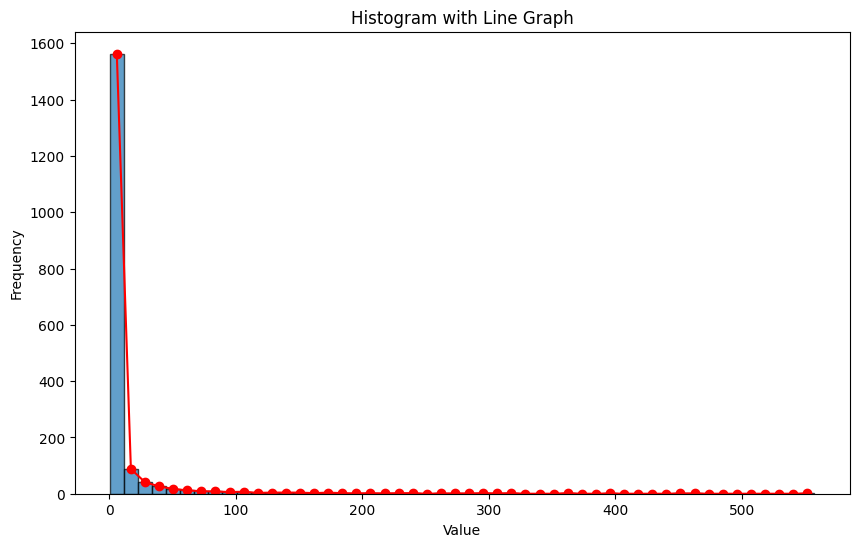

In [40]:
obs_hes.eigenvalue_distribution(values)

In [ ]:
#@title Ax = λx の確認（多次元）

# 固有値ベクトルから対角行列を作成する
val2 = np.diag(values)

In [ ]:
print(f'{val2.shape=}')
print(f'{vectors.shape=}')
print(f'{B.shape=}')

In [ ]:
left = np.matmul(B, vectors)

In [ ]:
right = np.matmul(vectors, val2)

In [ ]:
print(f'{right=}')

In [ ]:
left2 = np.round(left, 2)
right2 = np.round(right, 2)

In [ ]:
print(f'{left=}')
print(f'{right=}')